In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new


 98% 325M/331M [00:08<00:00, 27.9MB/s]
100% 331M/331M [00:08<00:00, 41.3MB/s]


In [3]:
!unzip -qq utkface-new.zip

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from config import *

In [3]:
%%writefile config.py 

epochs = 10
width = height = 224

Overwriting config.py


In [4]:
images = [] # X
ages = [] # Y

for image_name in os.listdir('crop_part1')[0: 9000]:
    parts = image_name.split('_')
    ages.append(int(parts[0]))

    image = cv2.imread(f'crop_part1/{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)


In [5]:
images = pd.Series(images, name='Images')
ages = pd.Series(ages, name='Ages')

df = pd.concat([images, ages], axis=1)
df.head()

,Images,Ages
0,"[[[255, 251, 248], [255, 251, 248], [253, 252,...",1
1,"[[[198, 184, 173], [196, 182, 171], [194, 180,...",65
2,"[[[225, 208, 198], [228, 211, 201], [231, 214,...",2
3,"[[[45, 26, 28], [45, 26, 28], [44, 25, 27], [4...",3
4,"[[[25, 16, 7], [23, 14, 5], [21, 12, 3], [21, ...",46


1


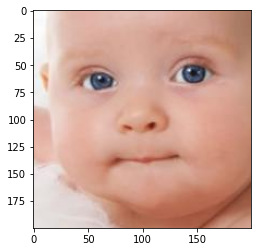

In [6]:
print(df['Ages'][0])
plt.imshow(df['Images'][0])

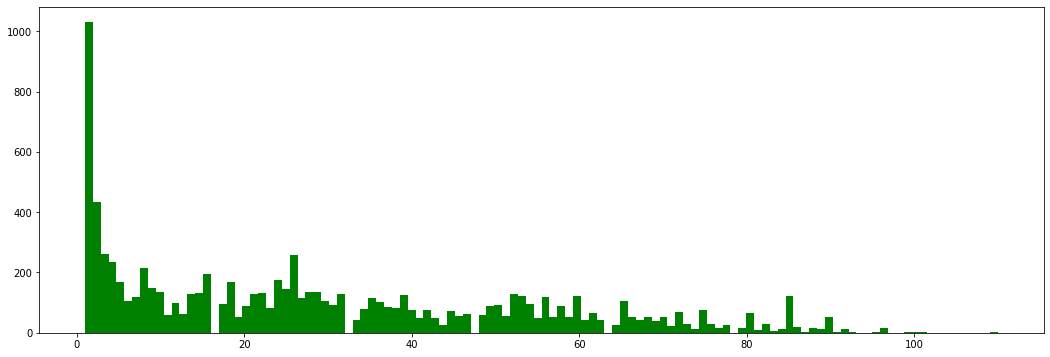

In [7]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=116, color='green')
plt.show()

In [8]:
under_4 = []

for i in range(len(df)):
  if df['Ages'].iloc[i] <= 4:
    under_4.append(df.iloc[i])

under_4 = pd.DataFrame(under_4)
under_4 = under_4.sample(frac=0.3)

up_4 = df[df['Ages'] > 4]

df = pd.concat([under_4, up_4])

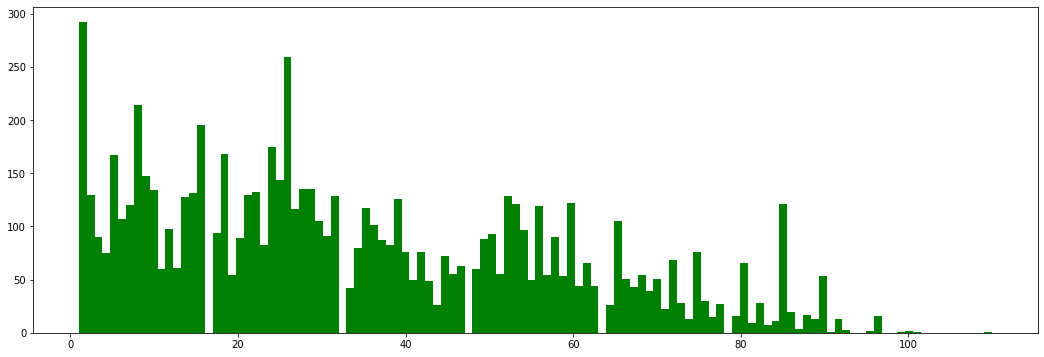

In [9]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=116, color='green')
plt.show()

In [10]:
df = df[df['Ages'] < 90]


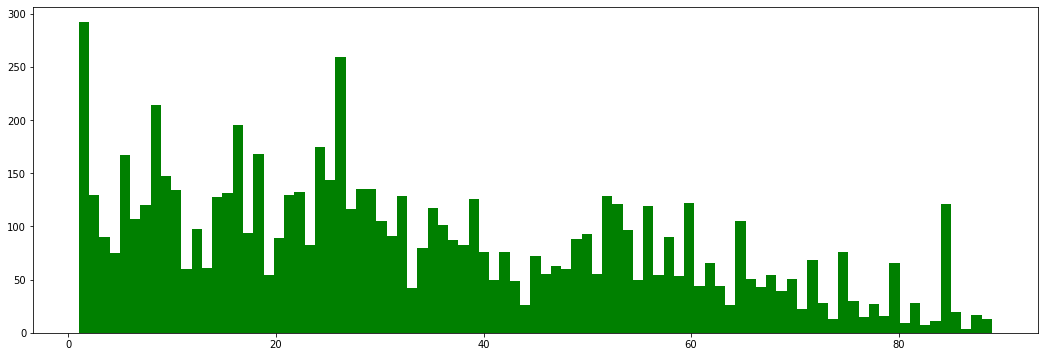

In [11]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=89, color='green')
plt.show()

In [12]:
X = []
Y =[]

for i in range(len(df)):
  df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i], (width, height))

  X.append(df['Images'].iloc[i])
  Y.append(df['Ages'].iloc[i])

X= np.array(X)
Y = np.array(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [13]:
X.shape

(7536, 224, 224, 3)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

In [15]:
x_train.shape

(6028, 224, 224, 3)

In [16]:
data_generator = ImageDataGenerator(rescale=1/.255,
                                    horizontal_flip=True)

train_data = data_generator.flow(x_train,
                                 y_train,
                                 batch_size=32)

val_data = data_generator.flow(x_val,
                                 y_val,
                                 batch_size=32)




In [27]:
base_moel = tf.keras.applications.MobileNetV2(
    input_shape=(width, height, 3),
    weights="imagenet",
    include_top=False,
    pooling='max'

)

In [28]:
for layer in base_moel.layers[:-4]:
  layer.trainable = False

In [29]:
model = tf.keras.Sequential([
                             base_moel,
                             Dense(1, activation='linear')
])

In [30]:
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [31]:
model.fit(train_data,
          validation_data=val_data,
          # epochs=epochs,
          epochs=epochs,
          shuffle=True)

Epoch 1/10
189/189 [==============================] - 25s 114ms/step - loss: 292.6793 - val_loss: 1058.7695
Epoch 2/10
189/189 [==============================] - 20s 108ms/step - loss: 213.4180 - val_loss: 1076.8850
Epoch 3/10
189/189 [==============================] - 20s 108ms/step - loss: 186.9483 - val_loss: 380.8790
Epoch 4/10
189/189 [==============================] - 20s 108ms/step - loss: 169.2562 - val_loss: 286.9685
Epoch 5/10
189/189 [==============================] - 20s 108ms/step - loss: 156.0138 - val_loss: 310.5450
Epoch 6/10
189/189 [==============================] - 20s 108ms/step - loss: 144.0965 - val_loss: 233.1867
Epoch 7/10
189/189 [==============================] - 20s 108ms/step - loss: 134.3723 - val_loss: 239.3290
Epoch 8/10
189/189 [==============================] - 20s 108ms/step - loss: 117.0349 - val_loss: 219.5290
Epoch 9/10
189/189 [==============================] - 20s 108ms/step - loss: 107.9280 - val_loss: 227.1812
Epoch 10/10
189/189 [==============

In [32]:
model.save('model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [35]:
!python3 inference.py --image_path 'input/08.jpg'

Age predicted:  [48.592476]


In [ ]:
!pip install retina-face
